<a href="https://colab.research.google.com/github/DataSpott/SGT-Analysis/blob/master/SGT_Automatisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization
Installation and import of the necessary libraries/tools.
Hit the play-button on the left-hand side to start.

In [39]:
#import of the necessary python-modules for computing the data
import pandas as pd
import numpy as np
import altair as alt
import xlrd as rd
import subprocess as sub

from scipy.optimize import curve_fit

#Optional download of test-data

In [3]:
!git clone https://github.com/DataSpott/SGT-Analysis.git

fatal: destination path 'SGT-Analysis' already exists and is not an empty directory.


# Data upload
Upload your raw-data .xls-file by clicking the play button and browse for your data.


In [40]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving 04.04.2019_Bk14073_Nitro 0-128_Dalba 0-8_Sunrise_rawdata.xlsx to 04.04.2019_Bk14073_Nitro 0-128_Dalba 0-8_Sunrise_rawdata (2).xlsx
User uploaded file "04.04.2019_Bk14073_Nitro 0-128_Dalba 0-8_Sunrise_rawdata.xlsx" with length 74404 bytes


# Converting/Parsing
Converts the uploaded Excel-file into an CSV-file.

In [41]:
#convert the Excel-file into a .csv-file:
data_xls = pd.read_excel(fn, sheet_name=0)                                      #variable which refers the first worksheet of the Excel-file with the name 'fn'
data_xls.to_csv('data.csv', encoding = 'utf-8')                                 #converts the Excel- to an .csv-file using the 'utf-8' encoding (for handling of special characters)

test = pd.read_csv('data.csv')                                                  #sets a test variable, which refers the created .csv-file
try:                                                                            #tries if the variable 'test' exists and give a True or False back
    test
except NameError:
    test_exists = False
else:
    test_exists = True

if test_exists == True:                                                         #if the test for the existence of 'test' was succesful the user gets informed that the conversion is done.
    print("Conversion of %s to .csv-file successful." %(fn))                    #Otherwise she/he is informed that the conversion failed.
else:
        print("Conversion of %s to .csv-file failed." %(fn))

Conversion of 04.04.2019_Bk14073_Nitro 0-128_Dalba 0-8_Sunrise_rawdata.xlsx to .csv-file successful.


#  Dataframe-creation
Creates a dataframe from the converted .csv-file.

In [42]:
#Build a pandas dataframe from the .csv-file:
data_raw = pd.read_csv('data.csv')                                              #creates a dataframe from the .csv-file

#deletes rows with unnecessary information (temp.-values and measurement-data):
data_raw = data_raw[:-5]                                                        #removes last 5 rows of the dataframe (-> measurment data)
data_raw = data_raw.iloc[1:]                                                    #removes the first row (-> temp.-values) by skipping it

#brings the dataframe in an optimised form for plotting:
data_raw = data_raw.rename(columns={'Unnamed: 0.1': 'Well'})                    #renames the column 'Unnamed: 0.1' to 'Well'
del data_raw['Unnamed: 0']                                                      #deletes the column with the name 'Unnamed: 0'

#deletes the 's' from the time-values:
for index in range(len(data_raw.columns)):                                      #for-loop over all columns
    data_raw.columns.values[index] =  data_raw.columns.values[index].replace('s', '')   #deletes the 's' at the end of the column name with the specific index

#add a '0' for Wells with single digit numbers: 
for index in range(len(data_raw)):                                              #for-loop over the row-count of the dataframe
    if len(data_raw.iloc[index, 0]) == 2:                                       #if-loop which tests if the Well-description is two letters long (e. g.: A1 = True; A10 = False)
        string = data_raw.iloc[index, 0]                                        #if the condition is true a variable 'string' is set up which refers the value (= Well-name) of the specific cell
        string = string[:1] + '0' + string[1:]                                  #a additional '0' is added in the second position of the string (by creating a new string from the old one) 
        data_raw.iloc[index, 0] = string                                        #the cell-value is overwritten by the new string

#displays dataframe 'data_raw':
data_raw










#WIP: Conversion for the Tecan-file
#comp_list = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','E12','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','G1','G2','G3','G4','G5','G6','G7','G8','G9','G10','G11','G12','H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12',]

#if cell == "Programm: Tecan i-control":
      #for rows in worksheet.nrows:
          #if worksheet.row_values(curr_row, 0, 1) == comp_list:
              #
              
        #else:
      #else:
       #output.csv = !head -n -5 output.csv


,Well,0,600,1200,1800,2400,3000,3600,4200,4800,5400,6000,6600,7200,7800,8400,9000,9600,10200,10800,11400,12000,12600,13200,13800,14400,15000,15600,16200,16800,17400,18000,18600,19200,19800,20400,21000,21600,22200,22800,...,42000,42600,43200,43800,44400,45000,45600,46200,46800,47400,48000,48600,49200,49800,50400,51000,51600,52200,52800,53400,54000,54600,55200,55800,56400,57000,57600,58200,58800,59400,60000,60600,61200,61800,62400,63000,63600,64200,64800,65400
1,A01,0.095,0.093,0.094,0.095,0.096,0.096,0.096,0.098,0.099,0.101,0.104,0.108,0.113,0.119,0.128,0.139,0.153,0.171,0.191,0.214,0.234,0.246,0.263,0.285,0.306,0.333,0.363,0.4,0.439,0.48,0.516,0.558,0.602,0.644,0.679,0.719,0.759,0.799,0.836,...,1.26,1.265,1.269,1.273,1.277,1.28,1.284,1.283,1.285,1.287,1.288,1.289,1.29,1.29,1.29,1.289,1.288,1.286,1.283,1.281,1.278,1.275,1.271,1.268,1.264,1.261,1.257,1.253,1.249,1.246,1.242,1.239,1.234,1.231,1.228,1.224,1.221,1.218,1.214,1.211
2,A02,0.091,0.09,0.09,0.091,0.091,0.091,0.092,0.093,0.094,0.096,0.098,0.101,0.105,0.11,0.118,0.127,0.14,0.156,0.175,0.197,0.221,0.239,0.254,0.272,0.293,0.314,0.338,0.361,0.385,0.416,0.451,0.487,0.534,0.581,0.625,0.664,0.704,0.743,0.78,...,1.214,1.219,1.224,1.229,1.234,1.235,1.237,1.241,1.244,1.247,1.248,1.25,1.251,1.251,1.251,1.251,1.25,1.249,1.247,1.246,1.243,1.242,1.24,1.238,1.235,1.233,1.231,1.229,1.226,1.224,1.222,1.221,1.219,1.217,1.215,1.213,1.213,1.211,1.21,1.21
3,A03,0.088,0.087,0.087,0.087,0.087,0.087,0.087,0.088,0.088,0.088,0.089,0.089,0.09,0.091,0.093,0.095,0.098,0.102,0.107,0.114,0.124,0.135,0.151,0.169,0.19,0.209,0.227,0.243,0.261,0.282,0.304,0.328,0.347,0.369,0.394,0.426,0.461,0.501,0.543,...,1.132,1.137,1.141,1.145,1.15,1.154,1.158,1.162,1.165,1.168,1.169,1.169,1.17,1.172,1.172,1.171,1.17,1.169,1.167,1.164,1.161,1.158,1.155,1.15,1.146,1.141,1.137,1.132,1.127,1.123,1.118,1.113,1.108,1.103,1.098,1.093,1.088,1.083,1.077,1.073
4,A04,0.086,0.086,0.086,0.086,0.086,0.086,0.086,0.086,0.086,0.086,0.086,0.086,0.086,0.086,0.086,0.087,0.087,0.088,0.088,0.088,0.089,0.09,0.091,0.093,0.095,0.098,0.102,0.107,0.113,0.122,0.133,0.146,0.16,0.176,0.194,0.213,0.24,0.273,0.311,...,1.041,1.05,1.057,1.063,1.068,1.073,1.077,1.08,1.083,1.086,1.09,1.094,1.098,1.102,1.106,1.11,1.112,1.111,1.111,1.112,1.112,1.11,1.109,1.105,1.103,1.099,1.095,1.091,1.086,1.081,1.076,1.072,1.067,1.062,1.057,1.052,1.047,1.042,1.036,1.031
5,A05,0.089,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.088,0.089,0.089,0.089,0.09,0.09,0.091,0.091,0.093,0.094,0.095,...,0.831,0.846,0.857,0.869,0.882,0.893,0.906,0.92,0.935,0.95,0.966,0.98,0.995,1.009,1.022,1.035,1.044,1.05,1.056,1.062,1.066,1.07,1.074,1.077,1.081,1.084,1.088,1.094,1.099,1.104,1.107,1.108,1.104,1.105,1.104,1.102,1.099,1.098,1.094,1.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,H08,0.085,0.085,0.085,0.085,0.085,0.085,0.085,0.085,0.085,0.085,0.085,0.085,0.085,0.085,0.085,0.085,0.086,0.086,0.086,0.087,0.087,0.088,0.089,0.091,0.093,0.095,0.099,0.104,0.11,0.118,0.129,0.143,0.159,0.177,0.194,0.211,0.226,0.241,0.256,...,1.015,1.034,1.052,1.066,1.076,1.082,1.087,1.091,1.095,1.098,1.103,1.109,1.116,1.123,1.13,1.138,1.147,1.152,1.16,1.165,1.17,1.173,1.179,1.182,1.186,1.189,1.192,1.194,1.197,1.199,1.199,1.2,1.199,1.199,1.198,1.197,1.196,1.194,1.194,1.194
93,H09,0.087,0.087,0.087,0.086,0.086,0.086,0.087,0.086,0.087,0.087,0.086,0.087,0.086,0.086,0.086,0.087,0.087,0.086,0.087,0.087,0.087,0.087,0.087,0.087,0.087,0.088,0.088,0.089,0.089,0.09,0.091,0.093,0.095,0.098,0.102,0.107,0.114,0.123,0.134,...,0.879,0.903,0.925,0.948,0.971,0.993,1.013,1.033,1.048,1.061,1.072,1.082,1.087,1.092,1.098,1.101,1.109,1.1

# Wide-to-long-conversion
Melts the Excel-like (wide) structure of the generated dataframe into an easier processable long form.

In [43]:
#uses the panda melt-command to bring the dataframe from wide to long form, where Well is an 'ID#, by which specific values (Time & Value) are identified
data_melted = pd.melt(data_raw, id_vars = ['Well'], var_name = 'Time', value_name = 'Value')

#changes data type of the columns 'Time' & 'Value':
data_melted['Time'] = data_melted['Time'].astype(float)
data_melted['Value'] = data_melted['Value'].astype(float)

#displays new dataframe 'data_melted':
data_melted#[data_melted['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

,Well,Time,Value
0,A01,0.0,0.095
1,A02,0.0,0.091
2,A03,0.0,0.088
3,A04,0.0,0.086
4,A05,0.0,0.089
...,...,...,...
10555,H08,65400.0,1.194
10556,H09,65400.0,1.200
10557,H10,65400.0,1.189
10558,H11,65400.0,1.224


#Well-selection
Sorts all wells, depending on if a well is fitting for the sigmoid curve-fit or not.

problematic Wells: E06, E12 ,F06, F12, G06, G12, H12
Edge-cases: G04; G05

In [ ]:
well = input("Choose well by entering the well-name (e.g.: 'A01'):")
last_value = data_melted[data_melted['Well'] == well].iloc[-1, 2]
last_time = data_melted[data_melted['Well'] == well].iloc[-1, 1]
second_to_last_value = data_melted[data_melted['Well'] == well].iloc[-2, 2]
second_to_last_time = data_melted[data_melted['Well'] == well].iloc[-2, 1]
delta_x = last_time - second_to_last_time
delta_y = last_value - second_to_last_value
m = delta_y/delta_x
print(m)

#2.1666666666e-05
#2.3333333333e-05

# last_five_indexes = np.linspace(-1, -5, 5)
# last_five_values = []
# for index in last_five_indexes:
#     a = int(index)
#     y_value = data_melted[data_melted['Well'] == 'G03'].iloc[a, 2]
#     last_five_values.append(y_value)
# delta_1_2 = last_five_values[0] - last_five_values[1] 
# delta_2_3 = last_five_values[1] - last_five_values[2]
# delta_3_4 = last_five_values[2] - last_five_values[3]
# delta_4_5 = last_five_values[3] - last_five_values[4]
# delta_sum = delta_1_2 + delta_2_3 + delta_3_4 + delta_4_5
# print(delta_1_2, delta_2_3, delta_3_4, delta_4_5, delta_sum)

Choose Well by entering the well-name (e.g.: 'A01'):E06
4.666666666666652e-05


In [ ]:
#Well-list:
well_plate = list(data_melted['Well'])                                          #list of the Wells on the plate as specified in the ID-column of the dataframe "data_melted" 
well_plate = list(dict.fromkeys(well_index))                                    #deleting duplicates by converting the list into a dictionary and back into a list

#Lists for sorting:
last_values = []
fitting_wells = []
edge_cases = []
unfitting_wells = []

#sorting loop:
for well in well_plate:
    #initialize data
    y_data = list(data_melted[data_melted['Well'] == well]['Value'])
    
    #setting up conditions
    y_max = max(y_data)
    min_threshold = 5 * min(y_data)
    last_value = data_melted[data_melted['Well'] == well].iloc[-1, 2]
    last_time = data_melted[data_melted['Well'] == well].iloc[-1, 1]
    second_to_last_value = data_melted[data_melted['Well'] == well].iloc[-2, 2]
    second_to_last_time = data_melted[data_melted['Well'] == well].iloc[-2, 1]
    delta_x = last_time - second_to_last_time
    delta_y = last_value - second_to_last_value
    m = delta_y/delta_x
    #print(m)
    delta_threshold = 1.8e-05
    
    #sorting
    if y_max >= min_threshold:
        if m < delta_threshold:
            fitting_wells.append(well)
        else:
            edge_cases.append(well)
    else:
        unfitting_wells.append(well)

#Output for user
unfitting_wells_index = len(unfitting_wells)
edge_cases_index = len(edge_cases)
#print(unfitting_wells_index)

if unfitting_wells_index > 1:
    print("The wells %s aren´t fitting for the sigmoid curve-fit." %(unfitting_wells))
elif unfitting_wells_index == 1:
    print("The well %s isn´t fitting for the sigmoid curve-fit." %(unfitting_wells))

if edge_cases_index > 1:
    print("The wells %s are edge cases and so aren´t processed in the sigmoid curve-fit." %(edge_cases))
elif unfitting_wells_index == 1:
    print("The well %s is an edge case and so isn´t processed in the sigmoid curve-fit." %(edge_cases))

The wells ['E12', 'G06', 'G12', 'H12'] aren´t fitting for the sigmoid curve-fit.
The wells ['D06', 'E06', 'F05', 'F06', 'F10', 'F12', 'G01', 'G02', 'G03', 'G04', 'G05', 'G07', 'G09', 'G10', 'G11'] are edge cases and so aren´t processed in the sigmoid curve-fit.


#Curve-Fitting
Uses the dataframe to fit a sigmoid-curve to the data of each Well.

In [44]:
#Definition of the sigmoid-function:
def sigmoid(x, L, x0, k, n):                                                    #L = curve's maximum value; x0 = x-value of the sigmoid´s midpoint (turnpoint, where the curve is linear); k = logistic growth rate or steepness of the curve (; n = value for y at x = 0)
    y = L / (1 + np.exp(-k * (x - x0))) + n
    return y

#Well-list:
well_plate = list(data_melted['Well'])                                          #list of the Wells on the plate as specified in the ID-column of the dataframe "data_melted" 
well_plate = list(dict.fromkeys(well_plate))                                    #deleting duplicates by converting the list into a dictionary and back into a list

#function to find value that is closest to a given value:
def find_nearest(array, value):                                                 #defines a function which finds a value in an array which is closest to an given value
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

#Curve-Fitting:
fitted_values = []                                                              #sets an empty list "fitted_values" for use in the following loop

for well in well_plate:                                                         #for-loop over the Wells (= ID) in well_index
    #initialize data
    x_data = list(data_melted[data_melted['Well'] == well]['Time'])             #list of the Time-column values of the specific Well from the dataframe "data_melted" as x-values  
    y_data = list(data_melted[data_melted['Well'] == well]['Value'])            #list of the Values-column values of the specific Well from the dataframe "data_melted" as y-values  
    
    #initialize start-parameters for curve_fit
    y_max = max(y_data)                                                         #max value of the Values-column of the specific Well
    y_min = min(y_data)
    k = (y_max/1000)          
    half_index = int(len(x_data)/2)
    x0 = data_melted[data_melted['Well'] == well].iloc[half_index, 1]                   
    p0 = [y_max, x0, k, y_min]                                                  #initialize parameters for the sigmoid-function (= L, x0, k, n)
    
    #curve_fit
    popt, pcov = curve_fit(sigmoid, x_data, y_data, p0)
    
    #get fitted function
    fitted_y = sigmoid(x_data, *popt)                                           #creating the fitting curves values with the sigmoid function
    
    #append new y-values with corresponding Well to list
    fitted_values.append([well, np.array(x_data), fitted_y])                    #appending the fitted y-values together with their time and specific Well to the former empty list "fitted_values"
    
    #optional control
    # pylab.plot(x_data, y_data, 'o', label='data') #
    # pylab.plot(x_data, fitted_y, label='fit')  #
    # pylab.legend(loc='best')
    # pylab.show()
    # print(fitted_values)
    # input()

#displays list 'fitted_values':
#fitted_values)

#Manual curve-fitting
Let the user choose a well by input, for which the curve-fit is computed and plotted.

Choose Well by entering Well-name (e.g. 'A01'):A01
[0.095, 0.093, 0.094, 0.095, 0.096, 0.096, 0.096, 0.098, 0.099, 0.101, 0.104, 0.108, 0.113, 0.119, 0.128, 0.139, 0.153, 0.171, 0.191, 0.214, 0.234, 0.246, 0.263, 0.285, 0.306, 0.333, 0.363, 0.4, 0.439, 0.48, 0.516, 0.558, 0.602, 0.644, 0.679, 0.719, 0.759, 0.799, 0.836, 0.872, 0.909, 0.943, 0.973, 1.0, 1.024, 1.051, 1.072, 1.091, 1.109, 1.128, 1.145, 1.16, 1.175, 1.186, 1.194, 1.199, 1.203, 1.208, 1.212, 1.216, 1.22, 1.224, 1.228, 1.233, 1.237, 1.241, 1.244, 1.248, 1.252, 1.257, 1.26, 1.265, 1.269, 1.273, 1.277, 1.28, 1.284, 1.283, 1.285, 1.287, 1.288, 1.289, 1.29, 1.29, 1.29, 1.289, 1.288, 1.286, 1.283, 1.281, 1.278, 1.275, 1.271, 1.268, 1.264, 1.261, 1.257, 1.253, 1.249, 1.246, 1.242, 1.239, 1.234, 1.231, 1.228, 1.224, 1.221, 1.218, 1.214, 1.211] 
 [1.29, 33000.0, 0.0012900000000000001, 0.093]


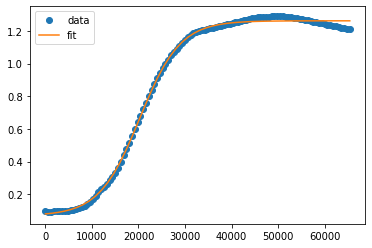

In [11]:
import pylab

#Definition of the sigmoid-function:
def sigmoid(x, L, x0, k, n):                                                       #L = curve's maximum value; x0 = x-value of the sigmoid´s midpoint (turnpoint, where the curve is linear); k = logistic growth rate or steepness of the curve (; n = value for y at x = 0)
     y = L / (1 + np.exp( -k * (x - x0))) + n
     return y

#function to find value that is closest to a given value:
def find_nearest(array, value):                                                 
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

#Well-selection
well = input("Choose Well by entering Well-name (e.g. 'A01'):")

#Curve-Fitting:
#initialize data
x_data = list(data_melted[data_melted['Well'] == well]['Time'])
y_data = list(data_melted[data_melted['Well'] == well]['Value'])

#initialize start-parameters for curve_fit
steps = (max(y_data)/1000)
half_index = int(len(x_data)/2)
x0 = data_melted[data_melted['Well'] == well].iloc[half_index, 1] 
p0 = [max(y_data), x0, steps, min(y_data)]

print(y_data, '\n', p0)

#curve_fit
popt, pcov = curve_fit(sigmoid, x_data, y_data, p0)

#get fitted function
x = np.linspace(min(x_data), max(x_data), 50)
y = sigmoid(x, *popt)

#Control-plot
#print(y)
pylab.plot(x_data, y_data, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.legend(loc='best')
pylab.show()

#Creation of second dataframe
Sets up a second dataframe with the new y-values from the curve-fit for each well

In [45]:
#creation of a list with the fitted values:
fitted_data = []                                                                #creating an empty list "fitted_data" for use in the following loop
for wells in range(len(fitted_values)):                                         #first for-loop over the length of the list "fitted_values". "i" specifies the Well
    for position in range(len(fitted_values[wells][1])):                        #second for-loop over the length of the nested list "new_y" (Index [id][1]) of the list "fitted_values". "j" specifies the position of the searched values.
        well = fitted_values[wells][0]                                          #variable which references the actual Well
        time = fitted_values[wells][1][position]                                        
        fitted_y = fitted_values[wells][2][position]                            #variabel which references the optimized y-values for the specified well
        fitted_data.append([well, time, fitted_y])                                    #appends the information for Well (="id") and fitted-y-value to the former empty list "fitted_data"
#fitted_data                                                                    #dipslays the list "fitted_data" for the user if the '#' at the beginning is deleted

#creation of a second dataframe:
data_fitted = pd.DataFrame(fitted_data, columns = ['Well', 'Time', 'Fitted Value']) #creates a dataframe with the columns 'Well', 'Time' and 'Value' and fills it with the information from the list "fitted_data"

#displays dataframe 'data_fitted':
#data_fitted[data_fitted['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

#Dataframe-merging
Merges the new y-values from data_fitted into the data_melted dataframe.

In [46]:
#create multiindex 'Well' and 'Time' for dataframe 'data_fitted':
data_fitted_multiindex = data_fitted.set_index(['Well', 'Time'], drop = True)

#check if dataframe 'data_merged' already a has a colum 'µ_max'
if hasattr(data_merged, 'Fitted Value'):
    
    #if TRUE delete the column and merge 'data_µ_max' into 'data_merged':
    del data_merged['Fitted Value']
    data_merged = data_melted.join(data_fitted_multiindex, on = ['Well', 'Time'])

#if FALSE merge 'data_µ_max' into 'data_merged':
else:
    data_merged = data_melted.join(data_fitted_multiindex, on = ['Well', 'Time'])

#display dataframe 'data_merged':
data_merged#[data_merged['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

,Well,Time,Value,Fitted Value
0,A01,0.0,0.095,0.079
1,A02,0.0,0.091,0.069
2,A03,0.0,0.088,0.074
3,A04,0.0,0.086,0.069
4,A05,0.0,0.089,0.075
...,...,...,...,...
10555,H08,65400.0,1.194,1.199
10556,H09,65400.0,1.200,1.187
10557,H10,65400.0,1.189,1.181
10558,H11,65400.0,1.224,1.216


#Plotting
Plots the growthcurves of the uploaded data together with the corresponding fitted sigmoid-function.

In [47]:
#deactivates the max_row limit of altair for the processed dataframe:
alt.data_transformers.enable('default', max_rows=None)

#raw-data-plot:
raw_data = alt.Chart(data_merged).mark_point(opacity=0.4, color = "teal"
#columns to plot with specifications for the axis:
).encode(
    alt.X('Time:Q', scale=alt.Scale(domain=(0, 66000)), axis=alt.Axis(title='Time [s]')),
    alt.Y('Value:Q', axis=alt.Axis(title='OD (600 nm)'))
#properties of the resulting diagramm:
).properties(
    width = 300,
    height = 200
)#.add_selection(
    #brush
#).facet(column = 'Well'
#).interactive()

#fitted-data-plot:
fitted_curves = alt.Chart(data_merged).mark_line(color = "black"
).encode(
    alt.X('Time:Q'),
    alt.Y('Fitted Value:Q')
 )

#command to layer the raw- and fitted-data-plots over each other and split them into many diagramms depending on the well:
alt.layer(raw_data, fitted_curves, data = data_merged).facet(column = 'Well')

alt.FacetChart(...)

problematic Wells: E06, E12 ,F06, F12, G06, G12, H12
Edge-cases: G04; G05

#Plot only fitted-curves

In [45]:
#deactivates the max_row limit of altair for the processed dataframe:
alt.data_transformers.enable('default', max_rows=None)

a = {1.0, 2.0, 0.5}

#Plot-command, where the 'Time'- & 'Value'-values for specific IDs (specified under .facet(column = 'Well')) are plotted in different diagramms:
brush = alt.selection(type='interval', encodings=['x'])

curves = alt.Chart(data_fitted).mark_line(color = "black").encode(
    alt.X('Time:Q', scale=alt.Scale(domain=(0, 66000)), axis=alt.Axis(title='Time [s]')),
    alt.Y('Fitted Value:Q', scale=alt.Scale(domain=(0, 1.5)), axis=alt.Axis(title='OD (600 nm)'))
).properties(
    width = 300,
    height = 200
).add_selection(
    brush
)#.facet(column = 'Well'
#).interactive()

line = alt.Chart().mark_rule(color='firebrick').encode(
    y= 'mean(a):Q',
    size = alt.SizeValue(3)#
).transform_filter(
   brush
)

alt.layer(curves, line, data=data_fitted).facet(column = 'Well')

alt.FacetChart(...)

#Alternative single (raw) data-plotting
Allows to choose specific Wells which shall be plotted. 

In [152]:
#Definition of the selection, which transforms the output of the upper plot by interating with the lower plot
selection = alt.selection_multi(fields = ['Well'])

#upper plot -> plots the growthcurve of the Wells
top = alt.Chart(data_merged).mark_line().encode(
    alt.X('Time:Q', scale=alt.Scale(domain=(0, 66000)), axis=alt.Axis(title='Time [s]')),
    alt.Y('Value:Q', scale=alt.Scale(domain=(0.0, 1.40)), axis=alt.Axis(title='OD (600 nm)')),
    color='Well:O'
).properties(
    width = 600,
    height = 500,
    title = 'Well'
).transform_filter(
    selection
)

#lower plot -> plots the Wells as dots, where the user can select a specific Well which then is plotted in the upper diagramm
bottom = alt.Chart().mark_circle().encode(
    x= 'Well',
    color = alt.condition(selection, alt.value('steelblue'), alt.value('lightgray'))
).properties(
    width=1200, height=100
).add_selection(
    selection
)

#plot-command which fuses both plots
alt.vconcat(
    top, bottom,
    data=data_melted
)

alt.VConcatChart(...)

#µ_max-calculation
Calculates the µ-values for the fitted sigmoid-curve of each well and detects the corresponding µ_max. 

µ_max is interpreted as turning point in the sigmoid-function.

In [ ]:
#Well-list:
well_plate = list(data_merged['Well'])
well_plate = list(dict.fromkeys(well_plate))

#create empty main-array:
µ_values = []

#primary for-loop over all wells:
for well in well_plate:
    
    #row-count for that well as condition for secondary for-loop:
    row_count = data_merged[data_merged['Well'] == well].shape[0]
    
    #create empty arrays:
    µ = []
    time = []

    #secondary loop over all rows for that well:
    for row in range(1, row_count):
        
        #initialize data:
        actual_value = data_merged[data_merged['Well'] == well].iloc[(row - 1), 3]
        actual_time = data_merged[data_merged['Well'] == well].iloc[(row - 1), 1]
        next_value = data_merged[data_merged['Well'] == well].iloc[row, 3]
        next_time = data_merged[data_merged['Well'] == well].iloc[row, 1]
        
        #process data:
        delta_x = next_time - actual_time
        delta_y = next_value - actual_value
        m = delta_y/delta_x
        
        #append processed data to arrays:
        µ.append(m)
        time.append(next_time)
    
    #append data to main-array:
    µ_values.append([well, µ, time])

#display resulting array:
µ_values   

Finds the µ_max-valus in the resulting µ_values-array.

In [111]:
#define function to find max µ-values in array:
def µ_max(array):
    
    #create empty main-array
    µ_max_list = []
    
    #primary for-loop over all wells:
    for wells in range(len(array)):
        
        #setup initial data:
        well = array[wells][0]
        µ_max = array[wells][1][0]
        µ_max_time = array[wells][2][0]
        
        #secondary for-loop over all µ-values for that well:
        for value in range(1, len(array[wells][1])):
            
            #if-condition to compare µ-values and find max µ:
            if array[wells][1][value] >= array[wells][1][(value - 1)]:
                
                #set new µ_max and corresponding time:
                µ_max = array[wells][1][value]
                µ_max_time = array[wells][2][value]
        
        #append data to main-array:
        µ_max_list.append([well, µ_max_time, µ_max])
    return µ_max_list

#start function µ_max with the µ_values-array:
µ_max_list = µ_max(µ_values)

#set Pandas display-precision to show 3 decimal places:
pd.set_option('display.precision', 3)

#create a dataframe from the resulting array:
data_µ_max = pd.DataFrame(µ_max_list, columns = ['Well', 'Time', 'µ_max'])

#display resulting dataframe:
data_µ_max#[data_µ_max['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

,Well,Time,µ_max
0,A01,20400.0,6.875e-05
1,A02,21000.0,6.161e-05
2,A03,24000.0,6.035e-05
3,A04,28200.0,5.663e-05
4,A05,37800.0,5.477e-05
...,...,...,...
91,H08,33600.0,4.829e-05
92,H09,37800.0,5.304e-05
93,H10,42000.0,5.317e-05
94,H11,46200.0,5.931e-05


Merges the µ_max-values from data_µ_max into the data_merged dataframe.

In [112]:
#create multiindex 'Well' and 'Time' for dataframe 'data_µ_max':
data_µ_max_multiindex = data_µ_max.set_index(['Well', 'Time'], drop = True)

#check if dataframe 'data_merged' already a has a colum 'µ_max'
if hasattr(data_merged, 'µ_max'):
    
    #if TRUE delete the column and merge 'data_µ_max' into 'data_merged':
    del data_merged['µ_max']
    data_merged = data_merged.join(data_µ_max_multiindex, on = ['Well', 'Time'])

#if FALSE merge 'data_µ_max' into 'data_merged':
else:
    data_merged = data_merged.join(data_µ_max_multiindex, on = ['Well', 'Time'])

#display dataframe 'data_merged':
data_merged#[data_merged['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

      Well     Time  Value  Fitted Value      µ_max
0      A01      0.0  0.095         0.079        NaN
1      A02      0.0  0.091         0.069        NaN
2      A03      0.0  0.088         0.074        NaN
3      A04      0.0  0.086         0.069        NaN
4      A05      0.0  0.089         0.075        NaN
...    ...      ...    ...           ...        ...
10555  H08  65400.0  1.194         1.199        NaN
10556  H09  65400.0  1.200         1.187        NaN
10557  H10  65400.0  1.189         1.181        NaN
10558  H11  65400.0  1.224         1.216        NaN
10559  H12  65400.0  0.102         0.102  1.472e-06

[10560 rows x 5 columns]


#Tangent in µ_max
Calculates the tangent in the point of µ_max and her intersection with the y-axis.

In [135]:
#Well-list:
well_plate = list(data_merged['Well'])
well_plate = list(dict.fromkeys(well_plate))

#create empty main-array:
y0_list = []

#for-loop over all wells:
for wells in well_plate:
    
    #setup initial data:
    m = data_merged[(data_merged['Well'] == wells) & (pd.notna(data_merged['µ_max']))]['µ_max'].values[0]
    x = data_merged[(data_merged['Well'] == wells) & (pd.notna(data_merged['µ_max']))]['Time'].values[0]
    y = data_merged[(data_merged['Well'] == wells) & (pd.notna(data_merged['µ_max']))]['Fitted Value'].values[0]
    
    #compute n from y = mx + n
    n = y - m * x
    
    #append data to main-array:
    y0_list.append([wells, m, n])

#create dataframe from the resulting array:
data = pd.DataFrame(y0_list, columns = ['Well', 'µ_max', 'y0'])

#display dataframe 'data':
data#[data['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'):")] #Optional: only a User-chosen Well is displayed

,Well,µ_max,y0
0,A01,6.875e-05,-0.728
1,A02,6.161e-05,-0.643
2,A03,6.035e-05,-0.831
3,A04,5.663e-05,-1.019
4,A05,5.477e-05,-1.467
...,...,...,...
91,H08,4.829e-05,-0.968
92,H09,5.304e-05,-1.340
93,H10,5.317e-05,-1.573
94,H11,5.931e-05,-2.066


#CutOff
User-dependent input of the OD-CutOff-value.

In [147]:
cut_off = float(input("Set CutOff: "))

Set CutOff: 0.6


float

#SGT-Calculation

In [151]:
#row-count as condititon for following loop:
row_count = data.shape[0]

#for-loop over all rows of 'data':
for row in range(row_count):
    
    #setup initial data:
    µ_max = data.loc[row, 'µ_max']
    y0 = data.loc[row, 'y0']
    
    #compute SGT and add it to 'data':
    data.loc[row, 'SGT'] = ((cut_off - y0) / µ_max) / 60

#displays dataframe 'data':
data#[data['Well'] == input("Choose well by entering the well-name (e.g.: 'A01'): ")] #Optional: only a User-chosen Well is displayed

,Well,µ_max,y0,SGT
0,A01,6.875e-05,-0.728,321.908
1,A02,6.161e-05,-0.643,336.288
2,A03,6.035e-05,-0.831,395.089
3,A04,5.663e-05,-1.019,476.451
4,A05,5.477e-05,-1.467,629.072
...,...,...,...,...
91,H08,4.829e-05,-0.968,541.121
92,H09,5.304e-05,-1.340,609.513
93,H10,5.317e-05,-1.573,681.308
94,H11,5.931e-05,-2.066,749.261


In [ ]:
#User-specification of plate-layout:
first_well_nmbr = input("Enter the number of the first Well of the plate (e.g. '01'): ")
last_well_nmbr = input("Enter the number of the first Well of the plate (e.g. '12'): ")

#Code-Base
Code saved for later use.

In [ ]:
#Initialization and import-commands
!pip install pdvega #installs pdvega
!jupyter nbextension install --sys-prefix --py vega3 #prepares a notebook to work with vega(?)

#if cell == "Programm: Tecan i-control":
      #num_rows = worksheet.num_rows - 1
      #curr_row = -1
      #while curr_row < num_rows:
        #if worksheet.cell(curr_row, 0) == comp_list:
          #curr_row += 1

        #else:
          #curr_row += 1
    #else:
       #data_xls = pd.read_excel (fn, sheet_name=0)
       #data_xls.to_csv ('output.csv', encoding='utf-8')
       #!head -n -5 output.csv


out = subprocess.Popen(['wc', '-l', 'my_text_file.txt'], 
           stdout=subprocess.PIPE, 
           stderr=subprocess.STDOUT)

#handling Excel-files
workbook = rd.open_workbook(fn) #define variable which refers to the Excel-file named "fn"
worksheet = workbook.sheet_by_index(0) #define variable which refers to the worksheet with index [0] inside the Excel-file saved in variable "workbook"
print(worksheet.row_values(0, 0, 1))
print(worksheet.nrows) #prints the row-count for the Excel-sheet referenced by the variable "worksheet"

#Pandas-Dataframe:
#Create panda dataframe
data = {'name': ['Jason', 'Molly', 'Tina', 'Jake', 'Amy'], 'year': [2012, 2012, 2013, 2014, 2014], 'reports': [4, 24, 31, 2, 3]} #creates a dataframe with the columns "name", "year" and "reports" with the associated values
df = pd.DataFrame(data, index = ['Cochice', 'Pima', 'Santa Cruz', 'Maricopa', 'Yuma']) #sets the row-indexes to the names, defined in the command

df.loc[-1] = [2, 3, 4]  # adding a row at index [-1] with the values 2, 3 & 4
df.index = df.index + 1  # shifting index (adding 1)
df = df.sort_index()  # sorting by index, used with the two commands before to add new rows to a dataframe (as first row)

df[:-3] #drop bottom 3 lines of a panda dataframe named df
list(data.index.values) #lists the indexes of the panda data frame
data = data.set_index('Data', drop = True) #sets the column with the name 'Data' as new index for the data frame
data.reset_index(level=0, inplace=True) #integrates the index column as new column with the index [0] 
list(data.columns) #lists the names of the columns of a panda data frame
data = data.rename(columns={'index': 'Time'}) #renames the column 'index' to 'Time'
data.iloc[0,0] #gives the value of the dataframe cell with the index [0, 0] (row, column), alternativly use data.loc[''] to search for a index name
type(data.iat[4,5]) #gives the type of the value of an panda data frame cell back
data = data.astype(float) #changes the datatype of all values in the dataframe to float
data = data.transpose() #transpose the dataframe
data_melted.groupby('Well')['Value'].max() #searches max-Value for every ID (here 'Well')
data_melted.groupby('Well')['Time'].median() #searches median for every ID (here 'Well')

y_median = data_melted[data_melted['Well'] == well]['Value'].median()       #computes the median of the "Value"-column for the specified Well
pos = find_nearest(data_melted[data_melted['Well'] == well]['Value'], y_median) #uses the function "find_nearest" to search the value in the "Value"-column of the specified Well which is closest to the computed median
x_median = data_melted.loc[(data_melted['Well'] == well) & (data_melted['Value'] == pos)].values[0][1]                               #gives the index of the cell with the value closest to the median #gives the time-value associated to the median of the "Value"-column     

#User-specified Plotting -> plots the diagramms for specific Wells which the user defines via input.
#deactivates the max_row limit of altair for the processed dataframe:
alt.data_transformers.enable('default', max_rows=None)

#Plot-command, where the 'Time'- & 'Value'-values for user-specified IDs (specified under .facet(column = 'Well')) are plotted in different diagramms:
chart = alt.Chart(data_melted).mark_line(color = "black").encode(
    alt.X('Time:Q', scale=alt.Scale(domain=(0, 66000)), axis=alt.Axis(title='Time [s]')),
    alt.Y('Value:Q', axis=alt.Axis(title='OD (600 nm)'))
).properties(
    width = 300,
    height = 200
).transform_filter(
    (alt.datum.Well == input("Enter Well-description for first diagramm (e. g.: A01):")) | (alt.datum.Well == input("Enter Well-description for second diagramm (e. g.: A01):"))
)

chart.facet(column = 'Well')

from google.colab import files
files.download('data.csv')
